### Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

import math

### Load images

In [3]:
imsize = 128
device = torch.device("cpu")

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    
    return image.to(device, torch.float)

style_img = image_loader('./images/picasso.jpg')
content_img = image_loader('./images/dancing.jpg')

assert style_img.size() == content_img.size()

### Display images

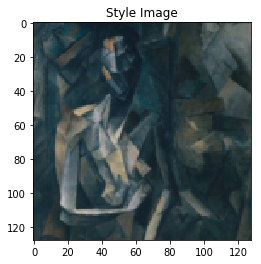

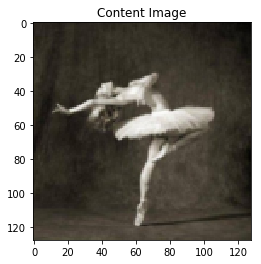

In [4]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

### Define losses

I sort of understand 

In [5]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [6]:
a, b, c, d = 1, 2, 3, 3

m1 = torch.ones((a * b, math.floor(c * d / 2)))
m2 = torch.zeros((a * b, math.ceil(c * d / 2)))

T = torch.cat((m1, m2), dim=1)

torch.mul(1 - T, torch.ones(a * b, c * d))

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1.]])

In [27]:
def gram_matrix(input, mask_feature):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)
    
    
    # Produce a spatial mask for the filter activations
    #m1 = torch.ones((a * b, math.floor(c * d / 2)))
    #m2 = torch.zeros((a * b, math.ceil(c * d / 2)))
    #T = torch.cat((m1, m2), dim=1)
    
    
    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
    
    masked_features = torch.mul(mask_feature, features)
    
    G = torch.mm(masked_features, masked_features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature, mask_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature, mask_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target,reduction='sum')
        return input

### Import pretrained model

In [8]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\Joschka/.torch\models\vgg19-dcbb9e9d.pth
100.0%


In [9]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [28]:
normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
mod1=nn.Sequential(normalization)
cnn2 = copy.deepcopy(cnn)
ll=1
for layer in cnn2.children():
        if isinstance(layer, nn.Conv2d):
            ll += 1
            name = 'conv_{}'.format(ll)
            mod1.add_module(name,layer)
            
        if name in content_layers_default:
            # add content loss:
            #print(mod1)
            target = mod1(content_img).detach()
            #print(target)
            content_loss = ContentLoss(target)
            mod1.add_module("content_loss_{}".format(ll), content_loss)
            #content_losses.append(content_loss)
            #print(mod1)

        if name in style_layers_default:
            # add style loss:
            #print(mod1)
            target_feature = mod1(style_img).detach()
            #print(target_feature)
            style_loss = StyleLoss(target_feature)
            mod1.add_module("style_loss_{}".format(ll), style_loss)
            #style_losses.append(style_loss)
            #print(mod1)

c:\users\joschka\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
c:\users\joschka\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


1 64 128 128
1 64 128 128
1 64 128 128
1 64 128 128
1 64 128 128
1 64 128 128
1 64 128 128
1 64 128 128
1 64 128 128
1 64 128 128
1 64 128 128
1 64 128 128
1 64 128 128
1 64 128 128
1 64 128 128
1 128 128 128
1 64 128 128
1 64 128 128
1 128 128 128
1 64 128 128
1 64 128 128
1 128 128 128
1 128 128 128


In [31]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4']

def get_style_model_and_losses_recep_avg(cnn, normalization_mean, normalization_std,
                               style_img, content_img, soft_mask,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model_avg_mask=nn.Sequential(normalization)
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        if isinstance(layer,nn.Conv2d):
            model_avg_mask.add_module(name, layer)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            recep_avg_mask = model_avg_mask(soft_mask).detach()
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature,recep_avg_mask)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

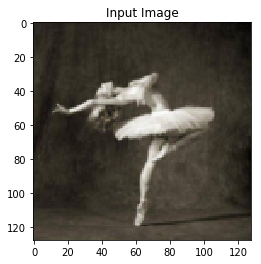

In [11]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
#input_img = torch.randn(content_img.data.size(), device=device)
#input_img = style_img.clone()


# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [12]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [33]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, soft_mask, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')    
    model, style_losses, content_losses = get_style_model_and_losses_recep_avg(cnn,
        normalization_mean, normalization_std, style_img, content_img, soft_mask)
        
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [34]:
m1=torch.ones((imsize,math.floor(imsize/2)))
m2=torch.zeros((imsize,math.ceil(imsize/2)))
soft_mask=torch.cat((m1,m2),dim=1)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, soft_mask)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Building the style transfer model..


c:\users\joschka\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
c:\users\joschka\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


AttributeError: 'Sequential' object has no attribute 'detach'